## Introduction
The purpose of this notebook is to benchmark the properties of randomly generated (normalized) surface expansions which will be used to generate data for the operator learning model.

In [14]:
import pincell_moment_utils.postprocessing as pp
from pincell_moment_utils.plotting import reconstruction_comparison
import numpy as np
np.random.seed(42)

mesh_tally = pp.SurfaceMeshTally('../data/source_statepoint.100.h5')
expansion = pp.random_surface_expansion(7, 5, mesh_tally.energy_filters, incident=True)

First, verify that each surface's flux function is normalized

In [15]:
expansion.integrate_flux(0)

1.0

In [16]:
expansion.flux_functions[0](0, np.pi + 0.1, 1E-06)

0.4549595738767353

Now inspect the generated flux function

/home/mlouis9/shared/Educational Stuffs/Classes/Spring 2025/Stat ML/Project/data_generation/src/pincell_moment_utils/plotting.py:53: RuntimeWarning: divide by zero encountered in divide
  plot_vals =  np.abs(mesh_vals -expansion_vals)/mesh_vals


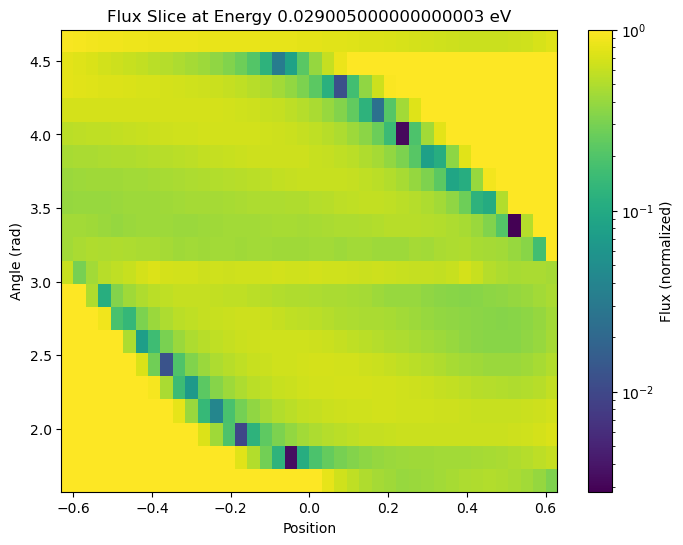

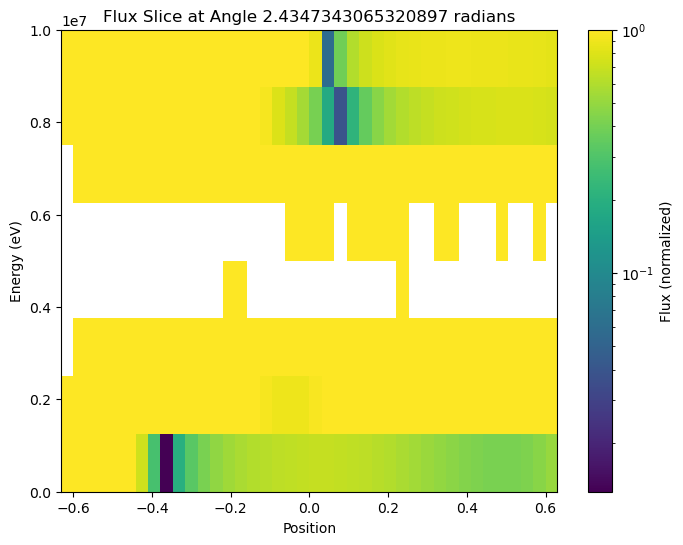

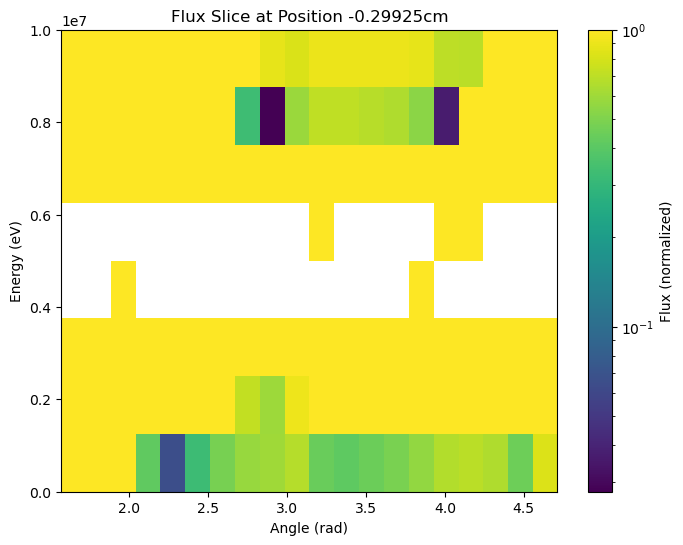

In [17]:
reconstruction_comparison(expansion, mesh_tally, 10, 5, 0, 0, incident=True)

In [18]:
surface = 0
# Note this tally is of outgoing flux, so we must permute the index of the mesh to get the correct angular and spatial bounds for
# the incoming direction
space_vals, angle_vals, energy_vals = mesh_tally.meshes[1]
energy_filter = mesh_tally.energy_filters[1]

expansion_vals = expansion.evaluate_on_grid(surface, (space_vals, angle_vals, energy_vals))

/home/mlouis9/shared/Educational Stuffs/Classes/Spring 2025/Stat ML/Project/data_generation/src/pincell_moment_utils/postprocessing.py:811: UserWarning: 20 angle(s) out of domain [-1.57, 1.57] on surface 0; example=1.649, clamping to 1.5707963267948966.
  avals_clamped = clamp_array_and_warn(avals, omin, omax, surface=surface, kind="angle")


Now check various slices of the generated flux profile

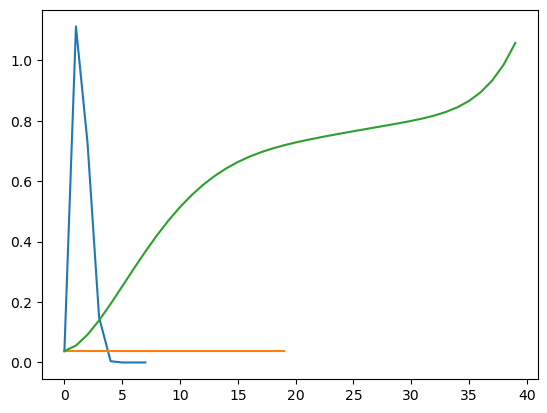

In [19]:
import matplotlib.pyplot as plt

plt.plot(expansion_vals[0, 0, :])
plt.plot(expansion_vals[0, :, 0])
plt.plot(expansion_vals[:, 0, 0])

All are seemingly reasonable, and apriori could be reasonable flux profiles

## Boundary Condition Parameterization
First, we note that the pincell has 90 degree rotational symmetry, and so we may parameterize the space of boundary conditions by considering first a set of $N_p$ randomly generated normalized single-surface incident flux functions. Then we uniformly generate a set of weights for the four surfaces $w_1, w_2, w_3, w_4$ such that each $w_i \in \text{linspace}[0,1, N_w]$. To respect the rotational symmetry of the domain (and to avoid generating unescessary samples), we consider only combinations of the $w_i$ that are unique up to cyclic permutations of the indices (corresponding to rotating the domain).

Finally, a pragmatic concern, since we don't expect to encounter any such examples in the end use application, we get rid of the weight sets that have three zeros.

First, an example of the weight generation is shown below

In [20]:
from pincell_moment_utils.sampling import generate_unique_weight_combinations
import pandas as pd

n = 9  # Number of discrete values for each weight in [0,1]
weights, count = generate_unique_weight_combinations(n)

df = pd.DataFrame(weights, columns=["w1", "w2", "w3", "w4"])

In [21]:
df

,w1,w2,w3,w4
0,0.000,0.000,0.125,0.875
1,0.000,0.000,0.250,0.750
2,0.000,0.000,0.375,0.625
3,0.000,0.000,0.500,0.500
4,0.000,0.125,0.125,0.750
5,0.000,0.125,0.250,0.625
6,0.000,0.125,0.375,0.500
7,0.000,0.250,0.250,0.500
8,0.000,0.250,0.375,0.375
9,0.125,0.125,0.125,0.625


### The Total Number of Datapoints
Now, since our pincell contains a simple circle, it is rotationally symmetric, and symmetric under reflections about both diagonals, the vertical, and the horizontal. This symmetry group has a name, it's called the Dihedral group of a square, or $D_4$. So, if all of the weights are the same for a given weight set, we want to only generate permutations (choices of profiles to go on surfaces) that are unique up to symmetries of $D_4$ (i.e. unique up to action by any one of the group symmetries of $D_4$). Now, if some of the weights are different, we essentially decompose the surfaces into different classes based on which surfaces share the same weights and again consider only permutations unique up to symmetries of $D_4$, but only for this subclass, then do the same for all other subclasses. Though technical sounding, this is a relatively intuitive consequence of the pincell symmetry. In technical jargon, generating these unique permutations given a set of weights might be called a "B urnside or Polya enumeration problem for four positions with partial identifications", with the additional fact that we don't care about permutations of surfaces with weight zero (since the resulting surface flux function is zero regardless of the profile chosen).

So, to count the total number of datapoints, assuming we're generating all of the unique permutations (which we don't necessarily have to, we could always randomly sample from these to avoid factorial scaing with $N_p$), we just sum up the number of permutations for each weight set. A simple example is shown below

In [22]:
from pincell_moment_utils.sampling import generate_unique_assignments

# Example usage:
N = 20  # Number of distinct objects
weights = [0, 0.5, 0, 0.5]  # Weights for surfaces
unique_assignments = generate_unique_assignments(N, weights)

There's a simple wrapper function for first generating the weight combinations, then generating the unique permutations for each weight combination, and returning everything

The dimensionality of the proposed expansion functionalization is $d = 7\times 5 \times 8 \times 4 = 1120$ (the last factor of 4 comes from the fact that the model will take coefficients for all 4 surfaces as input). We'll shoot for around $N=10^6$, which should provide many more than the conservative heuristic of $10\times N_{\text{DNN params}}$ and be cheapish (a pincell calculation with $10^6$ histories costs around $0.0027\ \text{CPU}\cdot \text{h}$, so for this many pincell calculation, it would cost around $7000\ \text{CPU}\cdot \text{h}$ or 10 hours on 100 cores, not too bad). For simplicity, and since the profile is what matters most, we'll only choose 4-7 values, and leave the rest for profile samples

In [23]:
from pincell_moment_utils.sampling import generate_all_unique_assignments

N_p = 50
N_w = 9
assignments = generate_all_unique_assignments(N_p, N_w)
print(sum([len(assignment[1]) for assignment in assignments]))

17869075


which is an order of magnitude too large, and yet only has a small number of samples. To increase the number of samples to something reasonable and still get something reasonable, we could randomly sample a portion of the relevant assignments for each weight group. Note that sampling $10^6$ coefficients from a bernstein expansion with randomly generated coefficients (which we'll have to do for each profile or $N_p$ times) costs $0.696\ \text{CPU}\cdot \text{h}$, which can afford us up to $N_p=1000$ without becoming too large relative to the pincell calculation cost. So we need to play with the fraction of combinations we sample to strike a nice balance between coefficient space coverage and boundary permutation space coverage while still acheiving the desired number of datapoints $\sim 10^6$. Clearly, sampling a fraction of $10^{-1}$ of the permutations will reduce $N$ by a factor of 10, so this gives us a simple way to tune the sample fraction and the number of profiles.

In [24]:
N_p = 200
N_w = 9
sample_frac = 0.01
assignments = generate_all_unique_assignments(N_p, N_w, sample_frac)
print(sum([len(assignment[1]) for assignment in assignments]))

0


Which is $\sim 10^6$ and will suffice for an initial dataset generation (at the very least). If we prefer to generate exactly $10^6$ (noting that the heuristic sample fraction doesn't really matter), we can instead call

In [25]:
N_p = 200
N_w = 9
sample_frac = 0.01
assignments = generate_all_unique_assignments(N_p, N_w, num_samples=int(1E+06))
print(sum([len(assignment[1]) for assignment in assignments]))

1000000
